In [62]:
print('Data assimilation on Lorenz model')

# load libraries
import numpy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# model parameters
s = 10.0
b = 8.0/3.0
r = 28.0

# time window and time step
T = 4.0
dt = 0.001
nt = int(T/dt)+1

# time frequency of observations
freqobs = 100
dtobs = freqobs*dt
ntobs = int(T/dtobs)+1

Data assimilation on Lorenz model


In [63]:
# resolution of Lorenz model
def lorenz(u0):
    u = numpy.zeros((nt,3))
    u[0,:] = u0
    for i in range(1,nt):
        u[i,0] = u[i-1,0]+dt*s*(u[i-1,1]-u[i-1,0])
        u[i,1] = u[i-1,1]+dt*(r*u[i-1,0]-u[i-1,1]-u[i-1,0]*u[i-1,2])
        u[i,2] = u[i-1,2]+dt*(u[i-1,0]*u[i-1,1]-b*u[i-1,2])
    return u

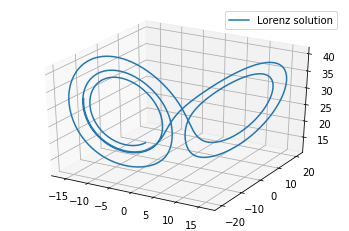

In [64]:
# true state and true solution
u0true = numpy.array([-4.62,-6.61,17.94])
utrue = lorenz(u0true)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(utrue[:,0],utrue[:,1],utrue[:,2])
ax.legend(['Lorenz solution'])

In [65]:
# Observation generation (with noise)
uobs = lorenz(u0true)
noiselevel = 1.0
noise = numpy.random.randn(nt,3)
uobs = uobs + noiselevel*noise

# Covariance matrix
R = numpy.identity(3)
Rinv = numpy.linalg.inv(R)

In [66]:
# Background state and trajectory
ub0 = numpy.array([-4.0,-6.0,18.0])
ub = lorenz(ub0)
B = numpy.identity(3)
Binv = numpy.linalg.inv(B)

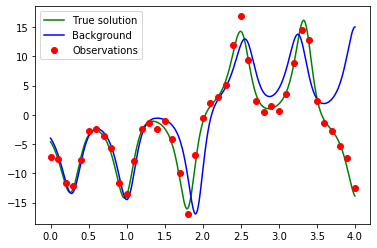

In [67]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.plot(numpy.arange(0,T+0.9*dt,dt),utrue[:,0],'g',numpy.arange(0,T+0.9*dt,dt),ub[:,0],'b',numpy.arange(0,T+0.9*dt,dt*freqobs),uobs[0:nt:freqobs,0],'ro')
ax2.legend(['True solution','Background','Observations'])

In [68]:
# 4D-VAR method
print('4D-VAR method')

4D-VAR method


In [69]:
# weights Jo/Jb
wo = freqobs/nt
wb = 1

In [70]:
# adjoint resolution
def lorenzadj(u):
    uadj = numpy.zeros((nt,3))
    # final condition
    uadj[nt-1,:] = 0.0
    # in case of final observation
    if numpy.mod(nt-1,freqobs) == 0:
        uadj[nt-1,:] = uadj[nt-1,:]+wo*Rinv.dot(u[nt-1,:]-uobs[nt-1,:])
    for i in range(nt-1,0,-1):
        uadj[i-1,0] = uadj[i,0]-dt*(s*uadj[i,0]-(r-u[i,2])*uadj[i,1]-u[i,1]*uadj[i,2])
        uadj[i-1,1] = uadj[i,1]-dt*(-s*uadj[i,0]+uadj[i,1]-u[i,0]*uadj[i,2])
        uadj[i-1,2] = uadj[i,2]-dt*(b*uadj[i,2]+u[i,0]*uadj[i,1])
        # in case of observation
        if numpy.mod(i-1,freqobs) == 0:
            uadj[i-1,:] = uadj[i-1,:]+wo*Rinv.dot(u[i-1,:]-uobs[i-1,:])
    return uadj

In [71]:
# cost function and gradient
def cost(u0):
    # Jb
    J = 0.5*wb*numpy.dot(u0-ub0,Binv.dot(u0-ub0))
    # direct solution
    u = lorenz(u0)
    # Jo
    for i in range(0,nt,freqobs):
        J = J+0.5*wo*numpy.dot(u[i,:]-uobs[i,:],Rinv.dot(u[i,:]-uobs[i,:]))
    return J
def gradient(u0):
    # direct solution
    u = lorenz(u0)
    # adjoint solution
    uadj = lorenzadj(u)
    # gradient
    gradJ = uadj[0,:]+wb*Binv.dot(u0-ub0)
    return gradJ


In [72]:
res = minimize(cost,ub0,method='Nelder-Mead',jac=gradient,options={'maxiter': 400})
res
# try with 'BFGS' method

 final_simplex: (array([[-4.50996454, -6.5528259 , 18.00319532],
       [-4.509959  , -6.55282199, 18.00320027],
       [-4.50995343, -6.55286541, 18.00319248],
       [-4.50989292, -6.55288889, 18.00321697]]), array([1.84848527, 1.84848527, 1.84848527, 1.84848527]))
           fun: 1.8484852654233663
       message: 'Optimization terminated successfully.'
          nfev: 183
           nit: 102
        status: 0
       success: True
             x: array([-4.50996454, -6.5528259 , 18.00319532])

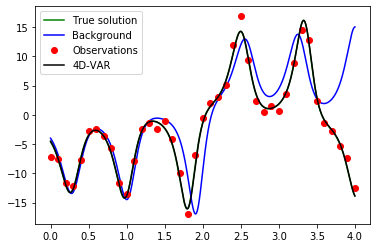

In [73]:
uopt0 = res.x
uopt = lorenz(uopt0)
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(numpy.arange(0,T+0.9*dt,dt),utrue[:,0],'g',numpy.arange(0,T+0.9*dt,dt),ub[:,0],'b',numpy.arange(0,T+0.9*dt,dt*freqobs),uobs[0:nt:freqobs,0],'ro',numpy.arange(0,T+0.9*dt,dt),uopt[:,0],'k')
ax3.legend(['True solution','Background','Observations','4D-VAR'])

In [74]:
# Kalman method
print('Kalman method')

Kalman method


In [75]:
# initialisation
ukf = numpy.zeros((nt,3))
ukf[0,:] = ub0
Pf = B

In [76]:
# Kalman filter
for i in range(0,nt):
    if i>0:
        # forecast
        # tangent linear model
        M = numpy.zeros((3,3))
        M[0,0] = 1-s*dt
        M[0,1] = s*dt
        M[0,2] = 0
        M[1,0] = dt*(r-ub[i-1,2])
        M[1,1] = 1-dt
        M[1,2] = -dt*ub[i-1,0]
        M[2,0] = dt*ub[i-1,1]
        M[2,1] = dt*ub[i-1,0]
        M[2,2] = 1-b*dt
        # update of the solution
        ukf[i,:] = M.dot(ukf[i-1,:])
        # update of the covariance matrix
        Pf = numpy.matmul(M,numpy.matmul(Pf,numpy.transpose(M)))
    # if available observations, then analysis
    if numpy.mod(i,freqobs) == 0:
        # Kalman matrix
        K = numpy.matmul(Pf,numpy.linalg.inv(Pf+R))
        # analysis
        xa = ukf[i,:]+K.dot(uobs[i,:]-ukf[i,:])
        ukf[i,:] = xa
        # update covariance matrix
        Pa = numpy.matmul(numpy.identity(3)-K,Pf)
        Pf = Pa


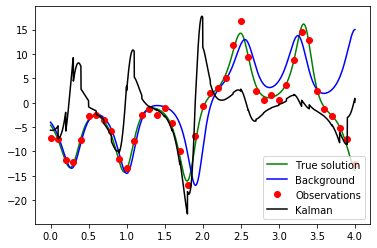

In [77]:
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.plot(numpy.arange(0,T+0.9*dt,dt),utrue[:,0],'g',numpy.arange(0,T+0.9*dt,dt),ub[:,0],'b',numpy.arange(0,T+0.9*dt,dt*freqobs),uobs[0:nt:freqobs,0],'ro',numpy.arange(0,T+0.9*dt,dt),ukf[:,0],'k')
ax4.legend(['True solution','Background','Observations','Kalman'])

In [78]:
# Extended Kalman method
print('Extended Kalman method')

Extended Kalman method


In [79]:
# initialisation
uekf = numpy.zeros((nt,3))
uekf[0,:] = ub0
Pf = B

In [80]:
# Extended Kalman filter
for i in range(0,nt):
    if i>0:
        # forecast with the nonlinear model
        uekf[i,0] = uekf[i-1,0]+dt*s*(uekf[i-1,1]-uekf[i-1,0])
        uekf[i,1] = uekf[i-1,1]+dt*(r*uekf[i-1,0]-uekf[i-1,1]-uekf[i-1,0]*uekf[i-1,2])
        uekf[i,2] = uekf[i-1,2]+dt*(uekf[i-1,0]*uekf[i-1,1]-b*uekf[i-1,2])
        # update the covariance matrix with the TLM
        M = numpy.zeros((3,3))
        M[0,0] = 1-s*dt
        M[0,1] = s*dt
        M[0,2] = 0
        M[1,0] = dt*(r-ub[i-1,2])
        M[1,1] = 1-dt
        M[1,2] = -dt*ub[i-1,0]
        M[2,0] = dt*ub[i-1,1]
        M[2,1] = dt*ub[i-1,0]
        M[2,2] = 1-b*dt
        Pf = numpy.matmul(M,numpy.matmul(Pf,numpy.transpose(M)))
    # if available observations, then analysis
    if numpy.mod(i,freqobs) == 0:
        # Kalman matrix
        K = numpy.matmul(Pf,numpy.linalg.inv(Pf+R))
        # analysis
        xa = uekf[i,:]+K.dot(uobs[i,:]-uekf[i,:])
        uekf[i,:] = xa
        # update covariance matrix
        Pa = numpy.matmul(numpy.identity(3)-K,Pf)
        Pf = Pa


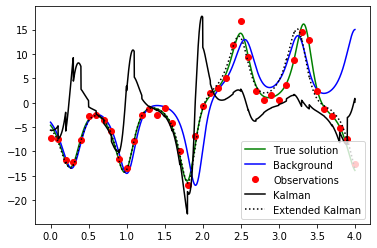

In [81]:
fig5 = plt.figure()
ax5 = fig5.add_subplot(111)
ax5.plot(numpy.arange(0,T+0.9*dt,dt),utrue[:,0],'g',numpy.arange(0,T+0.9*dt,dt),ub[:,0],'b',numpy.arange(0,T+0.9*dt,dt*freqobs),uobs[0:nt:freqobs,0],'ro',numpy.arange(0,T+0.9*dt,dt),ukf[:,0],'k',numpy.arange(0,T+0.9*dt,dt),uekf[:,0],'k:')
ax5.legend(['True solution','Background','Observations','Kalman','Extended Kalman'])

In [82]:
# Back and Forth Nudging method
print('BFN method')

BFN method


In [83]:
# BFN parameters
# number of iterations
nbfn = 3
# nudging coefficients
Kf = 0.4/dt
Kb = 0.8/dt

In [84]:
# forward nudging
def lorenzbfnf(ustart):
    ubfnf = numpy.zeros((nt,3))
    ubfnf[0,:] = ustart
    # (nonlinear) Lorenz model
    for i in range(1,nt):
        ubfnf[i,0] = ubfnf[i-1,0]+dt*s*(ubfnf[i-1,1]-ubfnf[i-1,0])
        ubfnf[i,1] = ubfnf[i-1,1]+dt*(r*ubfnf[i-1,0]-ubfnf[i-1,1]-ubfnf[i-1,0]*ubfnf[i-1,2])
        ubfnf[i,2] = ubfnf[i-1,2]+dt*(ubfnf[i-1,0]*ubfnf[i-1,1]-b*ubfnf[i-1,2])
        # add feedback in case of observations
        if numpy.mod(i,freqobs) == 0:
            ubfnf[i,:] = ubfnf[i,:]+dt*Kf*(uobs[i,:]-ubfnf[i,:])
    return ubfnf

In [85]:
# backward nudging
def lorenzbfnb(ufinal):
    ubfnb = numpy.zeros((nt,3))
    ubfnb[nt-1,:] = ufinal
    # backward Lorenz model
    for i in range(nt-1,0,-1):
        ubfnb[i-1,0] = ubfnb[i,0]-dt*s*(ubfnb[i,1]-ubfnb[i,0])
        ubfnb[i-1,1] = ubfnb[i,1]-dt*(r*ubfnb[i,0]-ubfnb[i,1]-ubfnb[i,0]*ubfnb[i,2])
        ubfnb[i-1,2] = ubfnb[i,2]-dt*(ubfnb[i,0]*ubfnb[i,1]-b*ubfnb[i,2])
        # add feedback in case of observations
        if numpy.mod(i-1,freqobs) == 0:
            ubfnb[i-1,:] = ubfnb[i-1,:]+dt*Kb*(uobs[i-1,:]-ubfnb[i-1,:])
    return ubfnb

In [86]:
# BFN iterations
ubfn = numpy.zeros((nt,3,2*nbfn))
# initialisation
ubfn[0,:,0] = ub0
for i in range(0,nbfn):
    if i>0:
        ubfn[0,:,2*i] = ubfn[0,:,2*i-1]
    # forward nudging
    utmp = lorenzbfnf(ubfn[0,:,2*i])
    ubfn[:,:,2*i] = utmp
    # backward nudging
    ubfn[nt-1,:,2*i+1] = ubfn[nt-1,:,2*i]
    utmp = lorenzbfnb(ubfn[nt-1,:,2*i+1])
    ubfn[:,:,2*i+1] = utmp


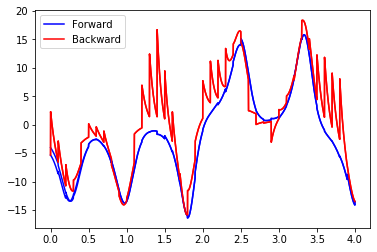

In [87]:
# plot of BFN trajectories
fig6 = plt.figure()
ax6 = fig6.add_subplot(111)
ax6.plot(numpy.arange(0,T+0.9*dt,dt),ubfn[:,0,0],'b',numpy.arange(0,T+0.9*dt,dt),ubfn[:,0,1],'r',numpy.arange(0,T+0.9*dt,dt),ubfn[:,0,2],'b',numpy.arange(0,T+0.9*dt,dt),ubfn[:,0,3],'r')
ax6.legend(['Forward','Backward'])

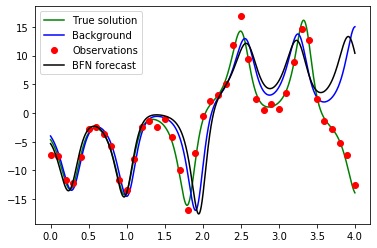

In [88]:
# forecast with the final BFN initial condition
u0bfn = ubfn[0,:,2*nbfn-1]
ubfnforecast = lorenz(u0bfn)
fig7 = plt.figure()
ax7 = fig7.add_subplot(111)
ax7.plot(numpy.arange(0,T+0.9*dt,dt),utrue[:,0],'g',numpy.arange(0,T+0.9*dt,dt),ub[:,0],'b',numpy.arange(0,T+0.9*dt,dt*freqobs),uobs[0:nt:freqobs,0],'ro',numpy.arange(0,T+0.9*dt,dt),ubfnforecast[:,0],'k')
ax7.legend(['True solution','Background','Observations','BFN forecast'])